In [61]:
import numpy as np
from datetime import datetime, timedelta
start_time = datetime.now().replace(microsecond=0)

In [62]:
np.random.seed(1991)

In [63]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
    ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.05),
                                                          ConstantVelocity(0.05)])
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

for k in range(1, 21):
    timesteps.append(start_time+timedelta(seconds=k))
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))

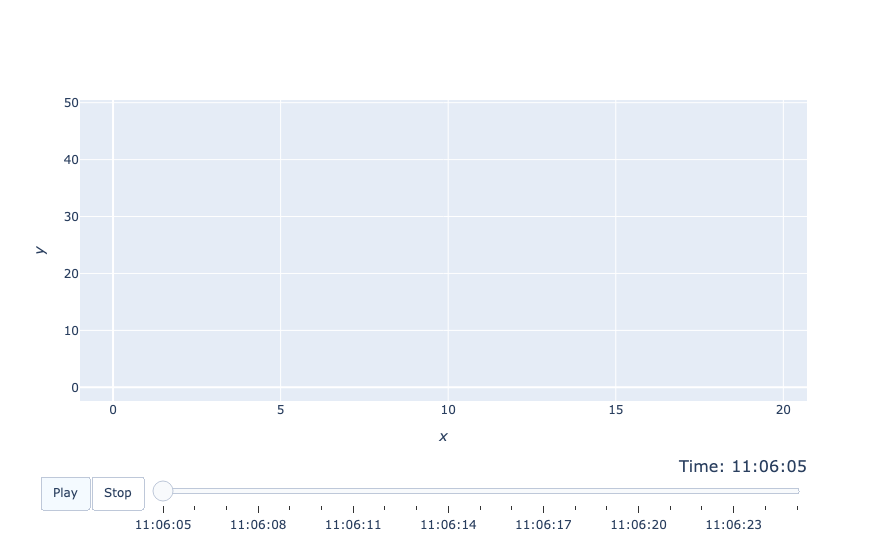

In [64]:
from stonesoup.plotter import AnimatedPlotterly
plotter = AnimatedPlotterly(timesteps, tail_length=0.3)
plotter.plot_ground_truths(truth, [0, 2])
plotter.fig

In [65]:
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange
sensor_x = 50  # Placing the sensor off-centre
sensor_y = 0

measurement_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.diag([np.radians(0.2), 1]),  # Covariance matrix. 0.2 degree variance in
    # bearing and 1 metre in range
    translation_offset=np.array([[sensor_x], [sensor_y]])  # Offset measurements to location of
    # sensor in cartesian.
)

In [66]:
from stonesoup.types.detection import Detection

measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement, timestamp=state.timestamp,
                                  measurement_model=measurement_model))

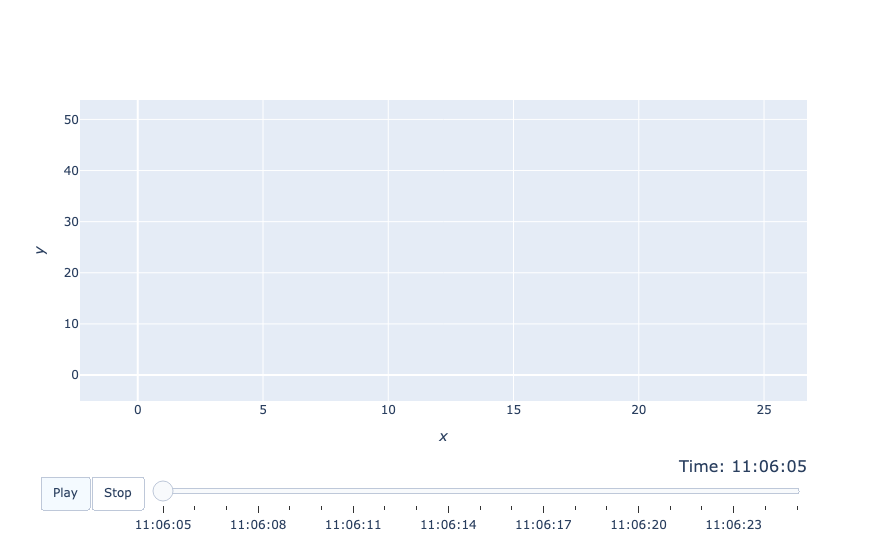

In [67]:
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

## Custom model

In [72]:
import importlib
import rhythmic_model
importlib.reload(rhythmic_model)
from rhythmic_model import RhythmicModel
from rhythmic_sharing import RhythmicNetwork

input_dims = 4
rhythmic_network = network = RhythmicNetwork(dt=1, input_dims=input_dims)
rhythmic_model = RhythmicModel(input_dims=input_dims, rhythmic_network=rhythmic_network)
rhythmic_model.ndim
rhythmic_model.covar(1)
rhythmic_model.rhythmic_network
rhythmic_model.matrix()

AttributeError: 'RhythmicModel' object has no attribute 'matrix'

In [69]:
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
predictor = ExtendedKalmanPredictor(rhythmic_model)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model)

In [70]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

In [71]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    break
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

(4, 1)
(4, 5)


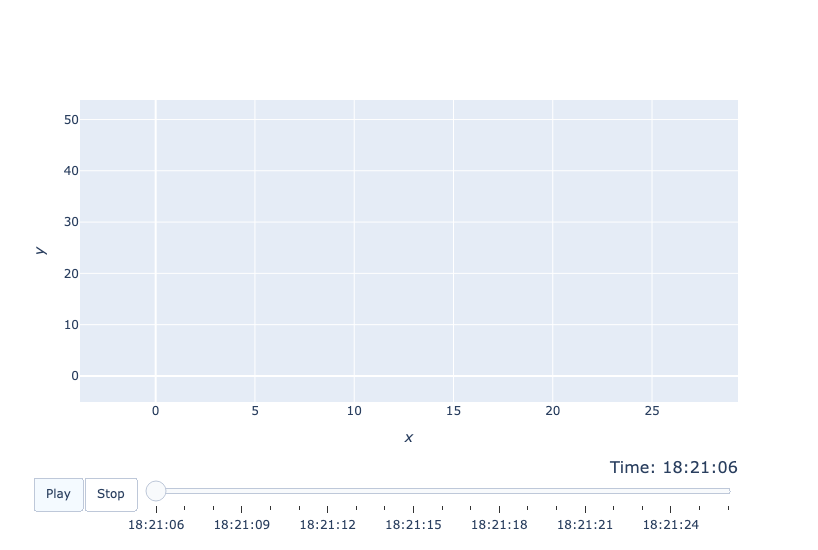

In [26]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig